## Explorating GLOTREC catalogue 
#### [Gimena del Rio](gdelrio.riande@gmail.com) & [Romina De León](rdeleon@conicet.gov.ar) 
#### ([HDLAB CONICET](https://hdlab.space/))
#### Notebook designed and maintained by Romina De León

## Goals:

- Download data from the [GLOTREC repository](https://itbc.gei.de/)
- Standardize and export the dataset for exploration and analysis
- Clean and prepare **GLOTREC** data related to **Argentine Textbooks**
- Exploring data and relationship between:
    - Authors and Publisher
    - Publisher and School Subjects
    - Publisher, Authors, School Subjects
- Work on similar visualizations as the ones that can be found nowadays in GLOTREC, though improved with a focus on specific periods.

### Libraries to use

Description:
* ``pandas``: for data cleaning, manipulation, and tabular representation
* ``numpy``: for efficient numerical and array operations
* ``matplotlib`` and ``seaborn``: for statistical and exploratory data visualization
* ``re``: for applying regular expressions in text normalization.
* ``openpyxl``: for reading and exporting Excel files.
* ``networkx``: for analyzing and visualizing relationships through network graphs.
* ``unidecode``: for removing diacritics and standardizing text encodings

#### Installation of packages if not already installed

In [ ]:

# Only needed once to install packages
%pip install -q pandas numpy matplotlib seaborn unidecode openpyxl squarify networkx pyvis


Note: you may need to restart the kernel to use updated packages.


#### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, openpyxl, networkx as nx
from unidecode import unidecode
import plotly.express as px
from pyvis.network import Network
import itertools

#### Setup visualization aesthetics for plots

In [3]:

sns.set_theme(style="whitegrid", palette="mako")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

#### Read the Excel file and Display first few rows

In [4]:

df = pd.read_excel(
    "data/itbc_export_2025.xlsx",
    usecols=lambda c: not c.startswith("Unnamed"),
    dtype={"Year": "float"}
)
print(df.info())
display(df.sample(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  335 non-null    object 
 1   Call Number         332 non-null    object 
 2   GLOTREC|Cat Link    335 non-null    object 
 3   Catalogue           335 non-null    object 
 4   Library Catalogue   335 non-null    object 
 5   Year                335 non-null    float64
 6   Publisher           335 non-null    object 
 7   Place               335 non-null    object 
 8   Title               335 non-null    object 
 9   Authors             321 non-null    object 
 10  Pages               333 non-null    object 
 11  Format              335 non-null    object 
 12  School Subject      335 non-null    object 
 13  Level of Education  335 non-null    object 
 14  Document Type       335 non-null    object 
 15  Country of Use      335 non-null    object 
dtypes: float

,ID,Call Number,GLOTREC|Cat Link,Catalogue,Library Catalogue,Year,Publisher,Place,Title,Authors,Pages,Format,School Subject,Level of Education,Document Type,Country of Use
265,655829911,"RA S-18(12,72)2",gei655829911,GEI,PPN=655829911,1972.0,Losada,Buenos Aires,"Educación democrática 2o. año, [Schülerbd.] Jo...","Delfino, Jorge Raúl",152 S.,Book,Social studies/politics,ISCED 2 - Lower secondary level,Textbook,Argentina
45,1027454313,"RA H-61(1,2010)3",gei1027454313,GEI,PPN=1027454313,2010.0,Aique Secundaria,Ciudad de Buenos Aires,"Historia 3, [Schülerband] La Argentina y el mu...","Arrascaeta, Eliana de | Garbarini, Laura | Les...","255 Seiten Illustrationen, Diagramme, Karten",Book,History,ISCED 2 - Lower secondary level,Textbook,Argentina
59,1027633390,"RA W-1(1,2016)4",gei1027633390,GEI,PPN=1027633390,2016.0,Santillana,Ciudad Autónoma de Buenos Aires,"Cuento con Jesús 4, [Schülerband] / editora: G...","Paz, Gabriela M. | Paz, Alicia | París, Walter",127 Seiten Illustrationen,Book,Religion,ISCED 1 - Primary level,Textbook,Argentina
304,733893112,"RA H-52(1,2012)",gei733893112,GEI,PPN=733893112,2012.0,Santillana,Buenos Aires,Historia Argentina en el contexto latinoameric...,"Andújar, Andrea N.","352 S. Ill., graph. Darst., Kt.",Book,History,ISCED 3 - Upper secondary level,Textbook,Argentina
149,654835918,"RA RA-42(2,52)",gei654835918,GEI,PPN=654835918,1952.0,Lasserre,Buenos Aires,Mi escuelita blanca libro de lectura para 2o. ...,"Robles de Perié, Aurora","[VI], 138 S. Ill., Kt.",Book,Mother tongue - Readers,ISCED 1 - Primary level,Reading Book,Argentina


#### Normalize 'Publisher' and 'Year' columns

Clean up spaces and convert to lowercase 
Normalization publishers with a mapping dictionary
Apply normalization in 'Publisher' column

In [ ]:
df['Publisher'] = df['Publisher'].str.strip().str.lower()
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
 
mapa_editoriales = {
    'a-z editora': 'A-Z Editora',
    'a-z ed.': 'A-Z Editora',
    'az editora': 'A-Z Editora',
    'estrada': 'Estrada',
    'estrada secundaria': 'Estrada',
    'angel estrada & cía.s.a.-editores': 'Estrada',
    'puerto de palos s.a. casa de édiciones': 'Puerto de Palos',
    'puerto de palos': 'Puerto de Palos',
    'aique primaria': 'Aique',
    'aique secundaria': 'Aique',
    'aique': 'Aique',
    'kapelusz': 'Kapelusz',
    'ed. kapelusz': 'Kapelusz',
    'kapelusz norma': 'Kapelusz',
    'tinta fresca': 'Tinta Fresca',
    'doce orcas ediciones': 'Doce Orcas',
    'doce orcas ed.': 'Doce Orcas',
    'doce orcas': 'Doce Orcas',
    'ed. stella': 'Stella',
    'ed. atlántida': 'Atlántida',
    'losada': 'Losada',
    'ed. troquel': 'Troquel',
    'imprenta mercur': 'Mercur',
    'imprenta de pablo e. coni, especial para obras': 'Coni',
    'coni': 'Coni',
    'igon': 'Igon',
    'igón': 'Igon',
    'goethe-inst.': 'Goethe-Institut',
    'cesarini': 'Cesarini',
    'cesarini hnos. ed.': 'Cesarini',
    'producciones mawis': 'Mawis',
    'editorial h.m.e.': 'HME',
    'imprenta y librería de mayo': 'Librería de Mayo',
    'librería del colegio, alsina y bolívar': 'Librería del Colegio',
    'cabaut, librería del colegio': 'Librería del Colegio',
    'alsina & bolívar, librería del colegio': 'Librería del Colegio',
    'librería del colegio': 'Librería del Colegio',
    'ed. crespillo': 'Crespillo',
    'f. crespillo': 'Crespillo',
    'f. crespillo editor': 'Crespillo',
    'ed. peuser': 'Peuser',
    'peuser': 'Peuser'
    }

df['Publisher'] = df['Publisher'].replace(mapa_editoriales).str.title()

#### Define a function to normalize author names according to specified rules
    1. Remove accents and extra spaces
    2. If there's a comma, we assume "Last, First" format
    3. if last name has multiple parts, keep them together
    4. select only the first given name
    5. rebuild normalized name
    6. if no comma, just title case the whole name
Apply function to authors column

In [ ]:

def normalizar_autor(nombre):
    if not isinstance(nombre, str) or not nombre.strip():
        return None

    # remove accents and extra spaces
    nombre = unidecode(nombre.strip())

    # If there's a comma, we assume "Last, First" format
    if ',' in nombre:
        apellido, resto = nombre.split(',', 1)
        apellido = apellido.strip()

        # if last name has multiple parts, keep them together
        apellido = re.sub(r'\s+', ' ', apellido)

        # select only the first given name
        resto = resto.strip()
        primer_nombre = resto.split()[0] if resto else ''

        # rebuild normalized name
        nombre_norm = f"{apellido.title()}, {primer_nombre.title()}"
    else:
        # if no comma, just title case the whole name
        nombre_norm = nombre.title()

    return nombre_norm.strip()

# Apply function to authors column ---
df['Authors'] = df['Authors'].fillna('').str.split('|').apply(lambda lst: [normalizar_autor(a) for a in lst if a])


### Graph Secction

#### Graph Publishers by Number of Books

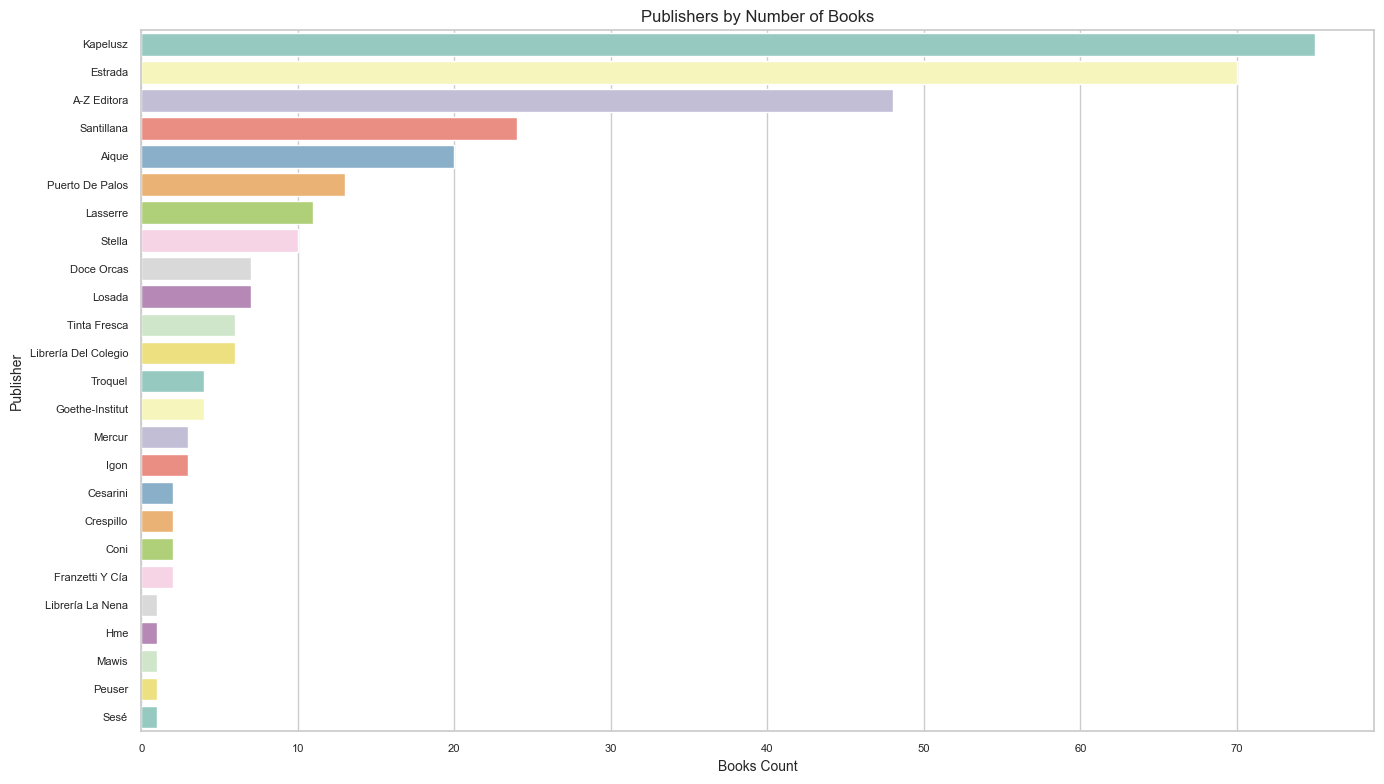

In [14]:
top = df['Publisher'].value_counts().head(25)
plt.figure(figsize=(14, 8))
sns.barplot(y=top.index, x=top.values, hue=top.index, palette="Set3", legend=False)
plt.xlabel('Books Count')
plt.ylabel('Publisher')
plt.title('Publishers by Number of Books')
plt.tight_layout()
plt.show()

##### Graph Publishers by Number of Books and Level of Education

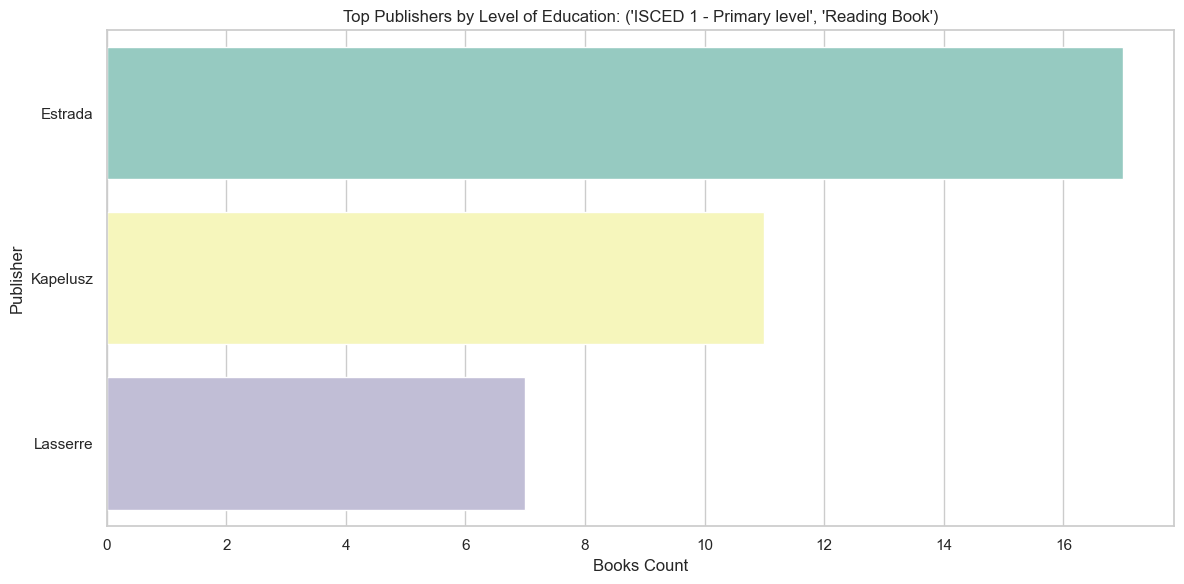

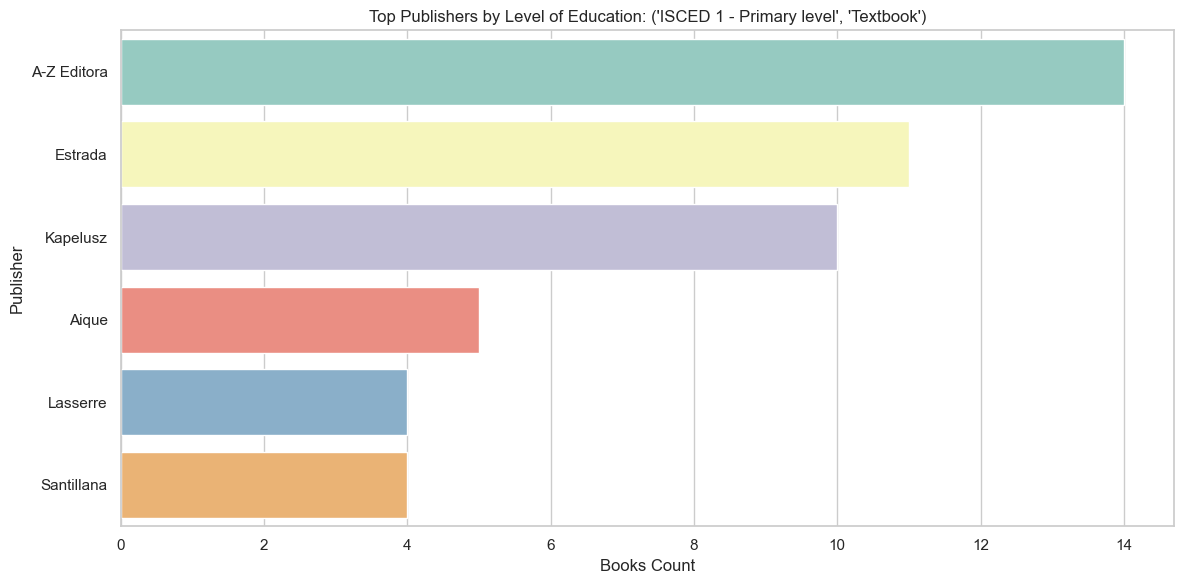

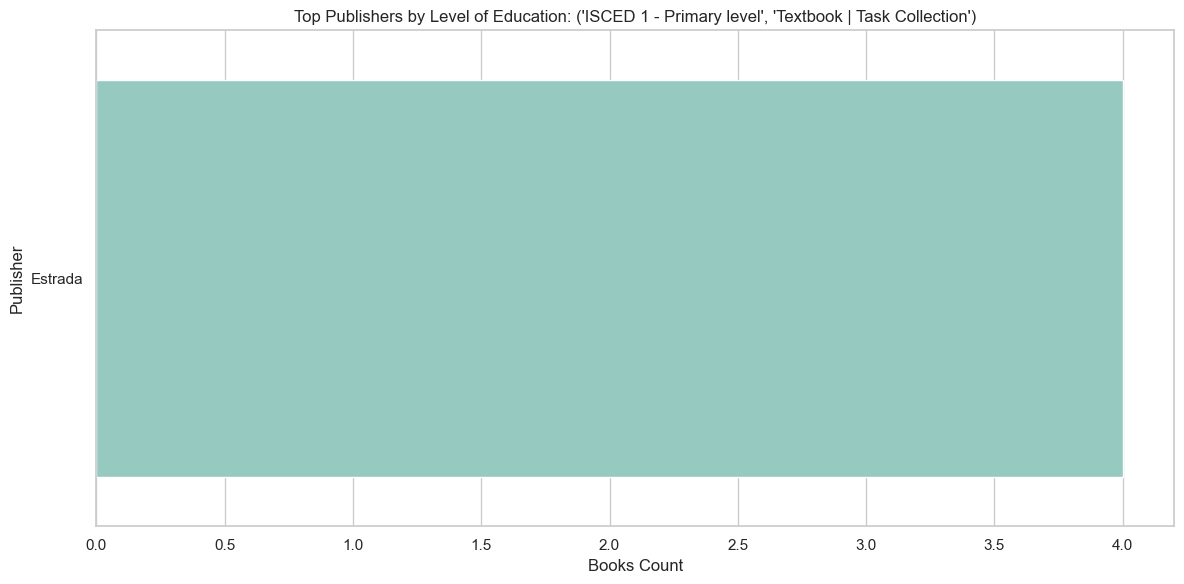

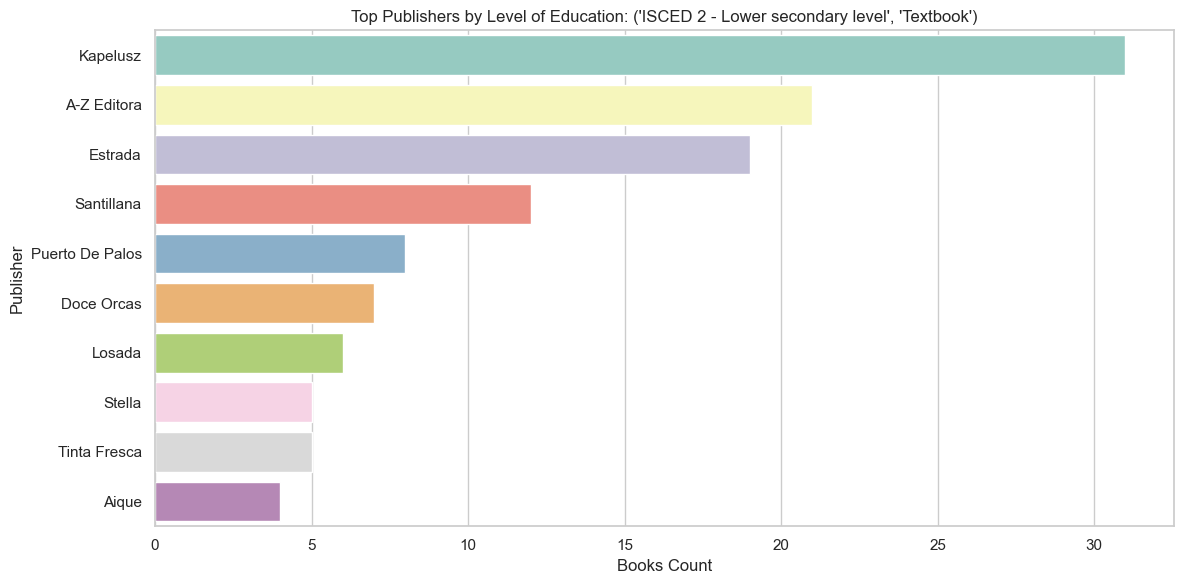

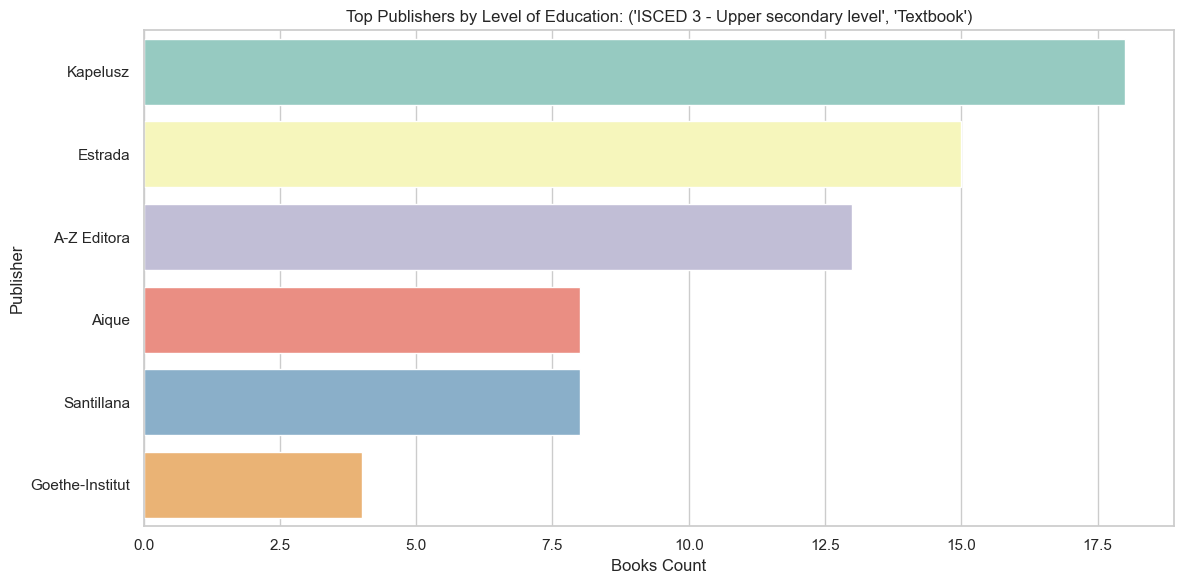

In [33]:

sns.set(style="whitegrid")
min_count = 4 
for level, subdf in df.groupby(['Level of Education', 'Document Type']):

    # top 25 publishers in this level
    top_publishers = (
        subdf['Publisher']
        .value_counts()
        .loc[lambda x: x >= min_count]
        .head(25)
        .reset_index()
    )
    # rename columns for clarity
    top_publishers.columns = ['Publisher', 'Books Count']
    if top_publishers.empty:
            continue
    # make bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_publishers,
        y='Publisher',
        x='Books Count',
        hue='Publisher',        # each bar a different color
        palette="Set3",
        legend=False
    )

    plt.title(f'Top Publishers by Level of Education: {level}')
    plt.xlabel('Books Count')
    plt.ylabel('Publisher')
    plt.tight_layout()
    plt.show()


#### Heatmap of Publishers vs School Subjects

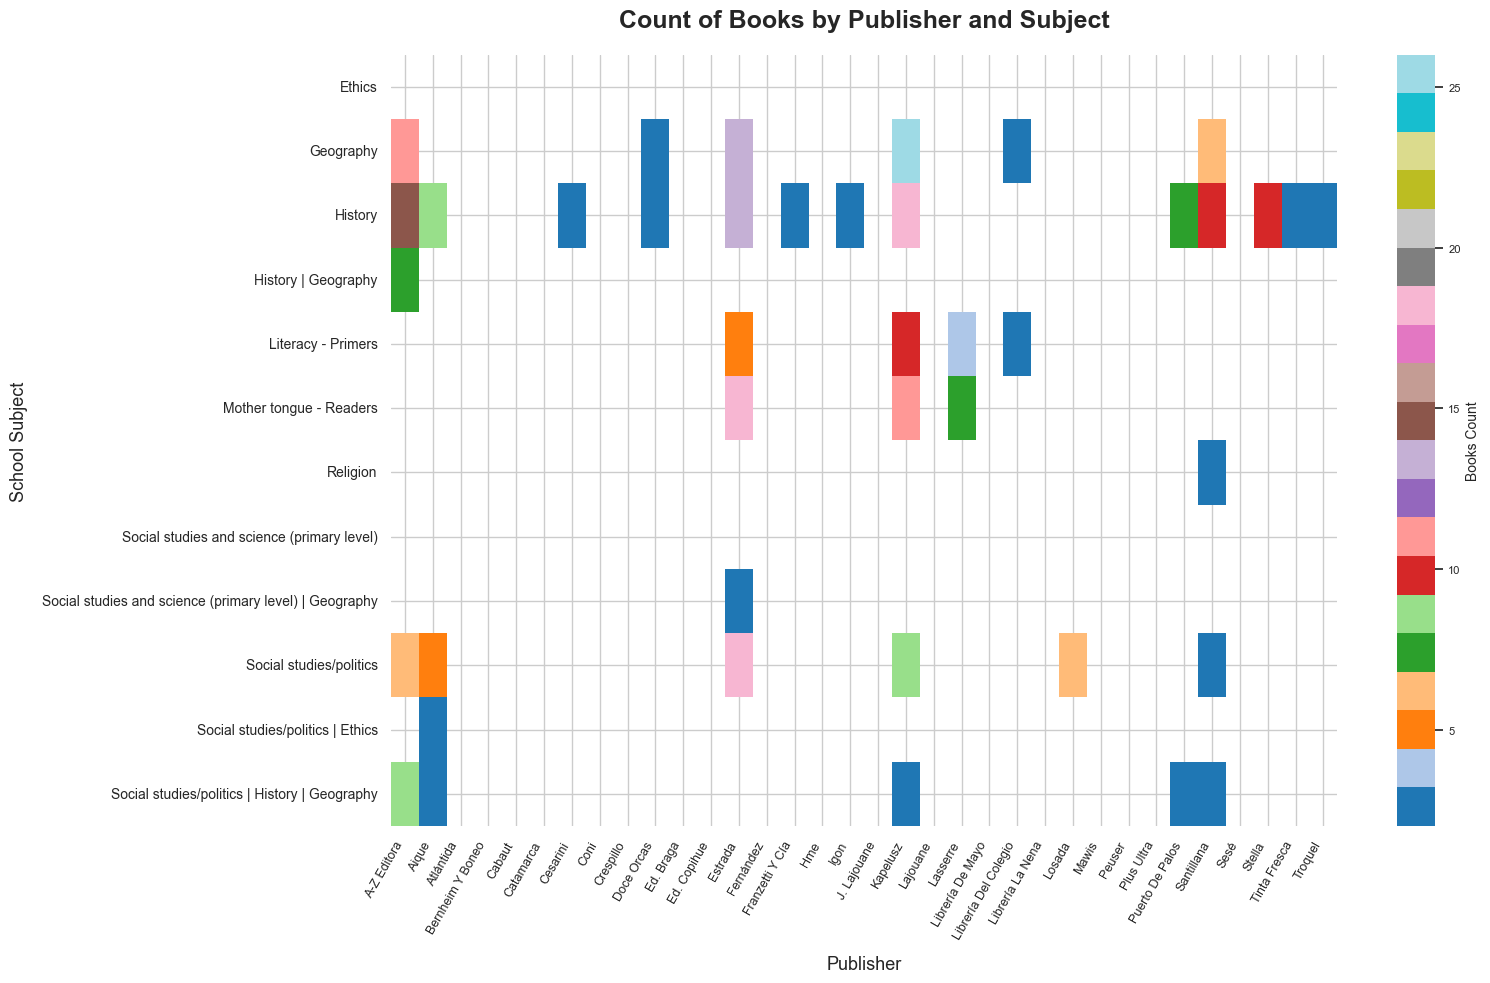

In [15]:

plt.figure(figsize=(16, 10))
(df
 .explode('Publisher')
 .query("`School Subject` != 'German taught in non-German-speaking countries'")
 .pipe(lambda d: sns.heatmap(
    pd.crosstab(d['School Subject'], d['Publisher']),
    #cmap='PiYG',
    cmap='tab20',
    annot=False,
    fmt='d',
    linecolor='gray',
    cbar_kws={'label': 'Books Count'},
    mask=(pd.crosstab(d['School Subject'], d['Publisher']) <= 1)
)))
plt.title('Count of Books by Publisher and Subject', fontsize=18, pad=20, weight='bold')
plt.xlabel('Publisher', fontsize=13, labelpad=10)
plt.ylabel('School Subject', fontsize=13, labelpad=10)
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

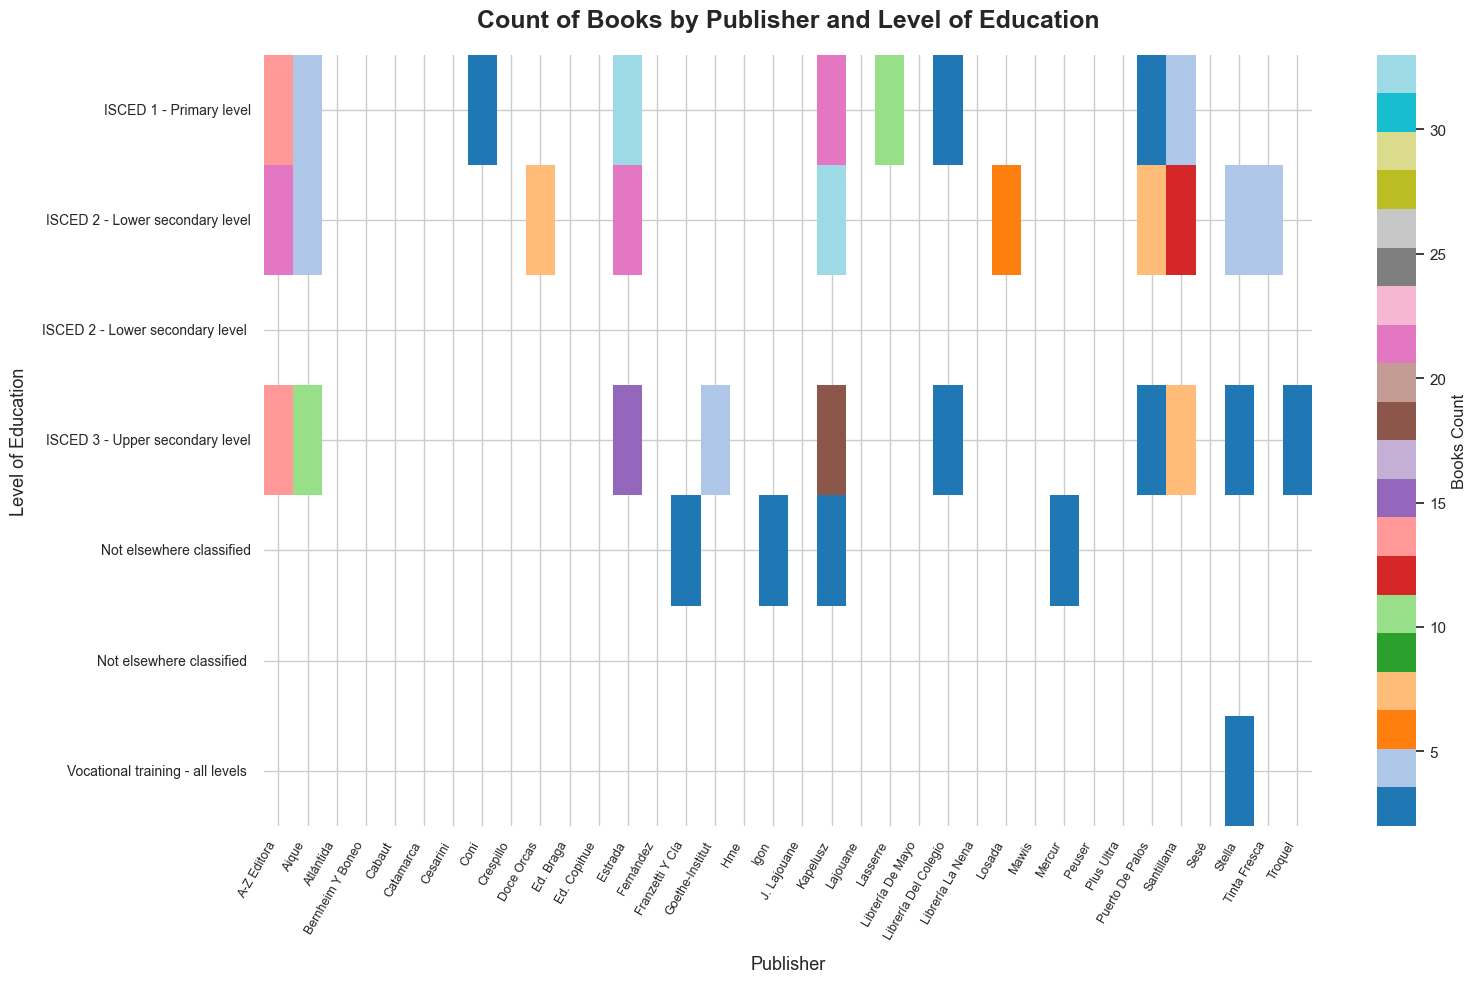

In [38]:
# Heatmap of Publishers vs Level of Education
df['Level of Education'] = df['Level of Education'].fillna('').str.split('|').str[0]
plt.figure(figsize=(16, 10))
(df
 .explode('Publisher')
 #.query("`School Subject` != 'German taught in non-German-speaking countries'")
 .pipe(lambda d: sns.heatmap(
    pd.crosstab(d['Level of Education'], d['Publisher']),
    #cmap='PiYG',
    cmap='tab20',
    annot=False,
    fmt='d',
    linecolor='gray',
    cbar_kws={'label': 'Books Count'},
    mask=(pd.crosstab(d['Level of Education'], d['Publisher']) <= 1)
)))
plt.title('Count of Books by Publisher and Level of Education', fontsize=18, pad=20, weight='bold')
plt.xlabel('Publisher', fontsize=13, labelpad=10)
plt.ylabel('Level of Education', fontsize=13, labelpad=10)
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

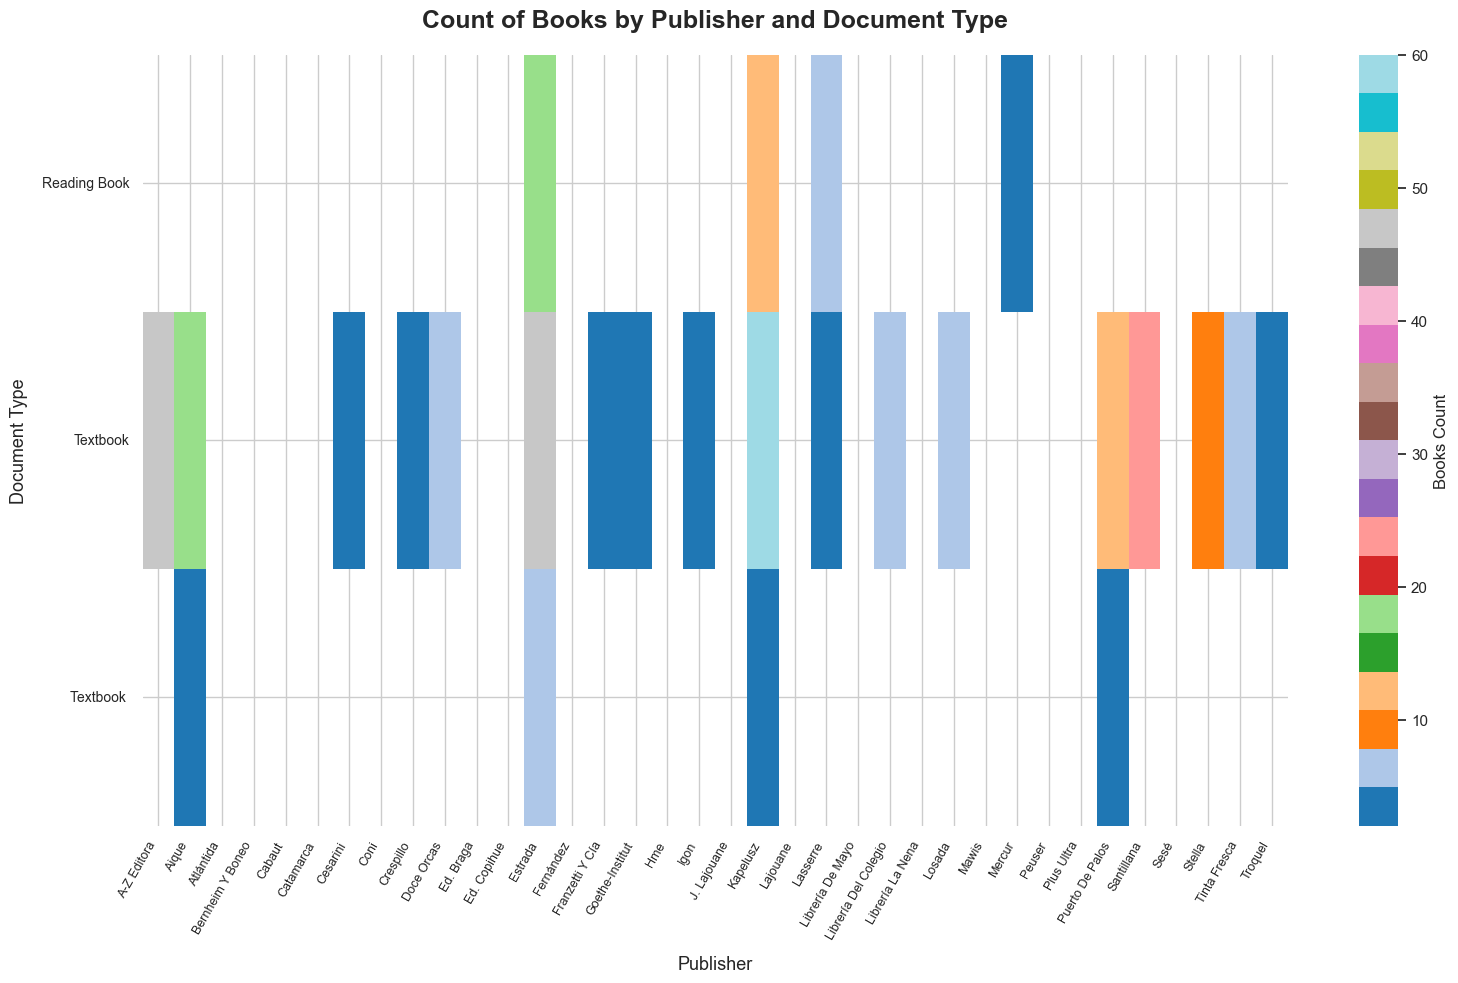

In [37]:
# Heatmap of Publishers vs Document Type
df['Document Type'] = df['Document Type'].fillna('').str.split('|').str[0]
plt.figure(figsize=(16, 10))
(df
 .explode('Publisher')
 #.query("`School Subject` != 'German taught in non-German-speaking countries'")
 .pipe(lambda d: sns.heatmap(
    pd.crosstab(d['Document Type'], d['Publisher']),
    #cmap='PiYG',
    cmap='tab20',
    annot=False,
    fmt='d',
    linecolor='gray',
    cbar_kws={'label': 'Books Count'},
    mask=(pd.crosstab(d['Document Type'], d['Publisher']) <= 1)
)))
plt.title('Count of Books by Publisher and Document Type', fontsize=18, pad=20, weight='bold')
plt.xlabel('Publisher', fontsize=13, labelpad=10)
plt.ylabel('Document Type', fontsize=13, labelpad=10)
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

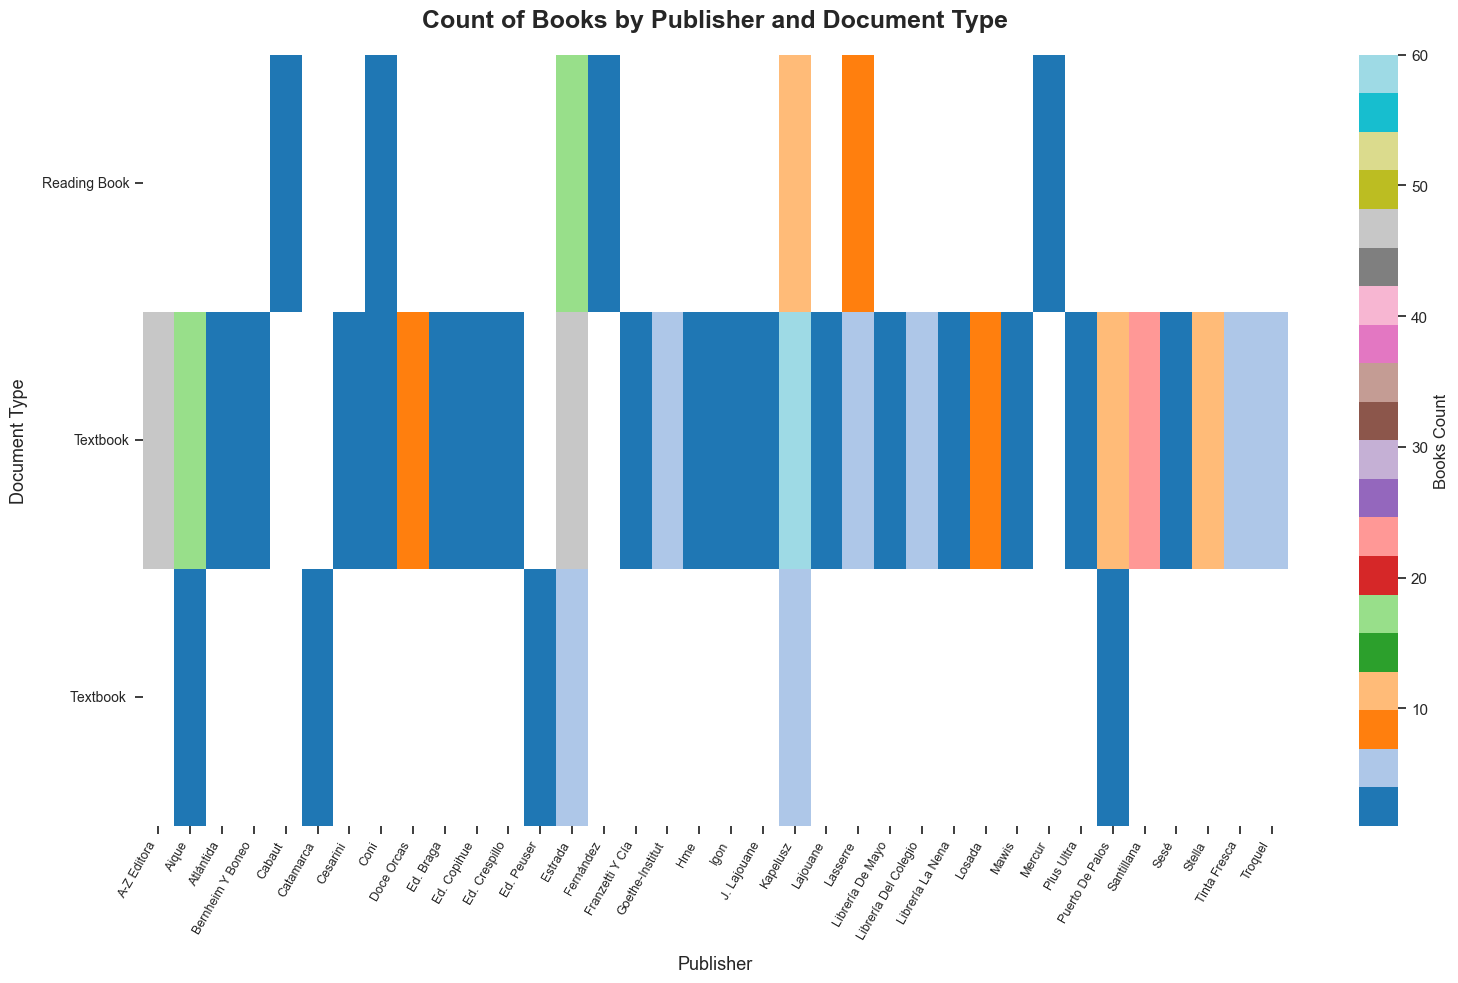

In [31]:
df['Document Type'] = df['Document Type'].fillna('').str.split('|').str[0]

# Heatmap of Publishers vs Document Type filtered 
plt.figure(figsize=(16, 10))
(df
 .explode('Publisher')
 #.query("`School Subject` != 'German taught in non-German-speaking countries'")
 .pipe(lambda d: sns.heatmap(
    pd.crosstab(d['Document Type'], d['Publisher']),
    #cmap='PiYG',
    cmap='tab20',
    annot=False,
    fmt='d',
    linecolor='gray',
    cbar_kws={'label': 'Books Count'},
    mask=(pd.crosstab(d['Document Type'], d['Publisher']) <= 0)
)))
plt.title('Count of Books by Publisher and Document Type', fontsize=18, pad=20, weight='bold')
plt.xlabel('Publisher', fontsize=13, labelpad=10)
plt.ylabel('Document Type', fontsize=13, labelpad=10)
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

## mejorar grafico
## ver colores

Dejar para mirada general, luego sumar por intervalo de 40 años o ver que combinacion queda mejor

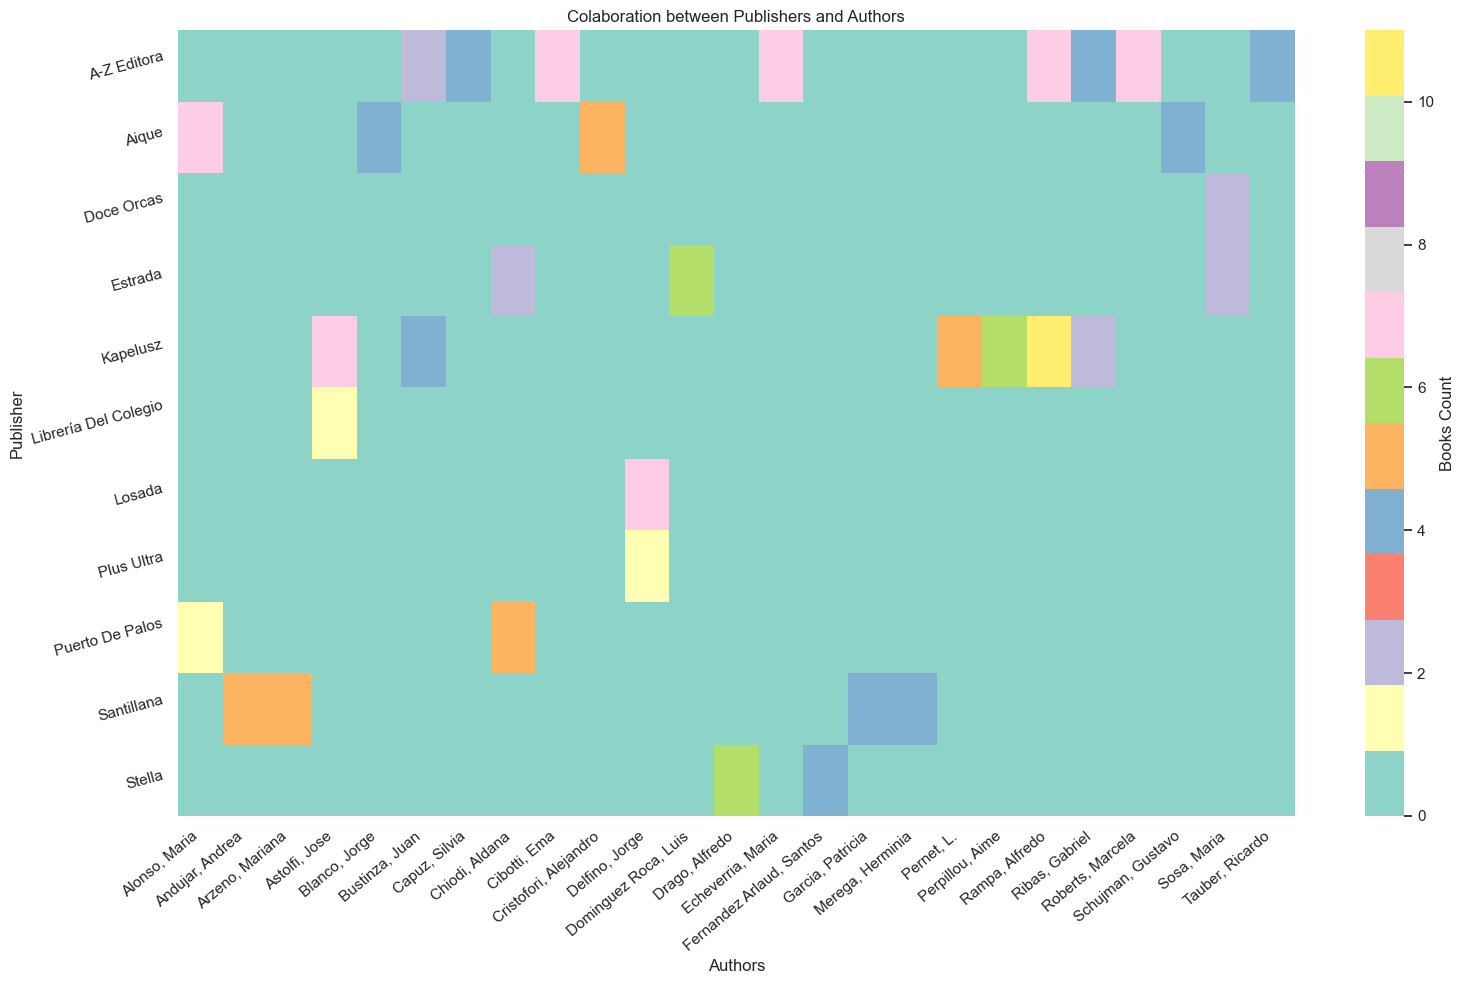

In [45]:
# Heatmap of Publishers vs Authors

plt.figure(figsize=(16, 10))
""" vmax = 45 """
(df
 .explode('Authors')
 .pipe(lambda d: d[
        d['Publisher'].isin(d['Publisher'].value_counts().nlargest(25).index) &
        d['Authors'].isin(d['Authors'].value_counts().nlargest(25).index)
    ])
 .pipe(lambda d: sns.heatmap(
     pd.crosstab(d['Publisher'], d['Authors']),
     cmap='Set3',
     annot=False,
     fmt='d',
     linecolor='gray',
     cbar_kws={'label': 'Books Count'}
    #vmax=vmax
 ))
)
plt.title('Colaboration between Publishers and Authors')
plt.xlabel('Authors')
plt.ylabel('Publisher')
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

#### Heatmap of Publishers vs Authors for decades

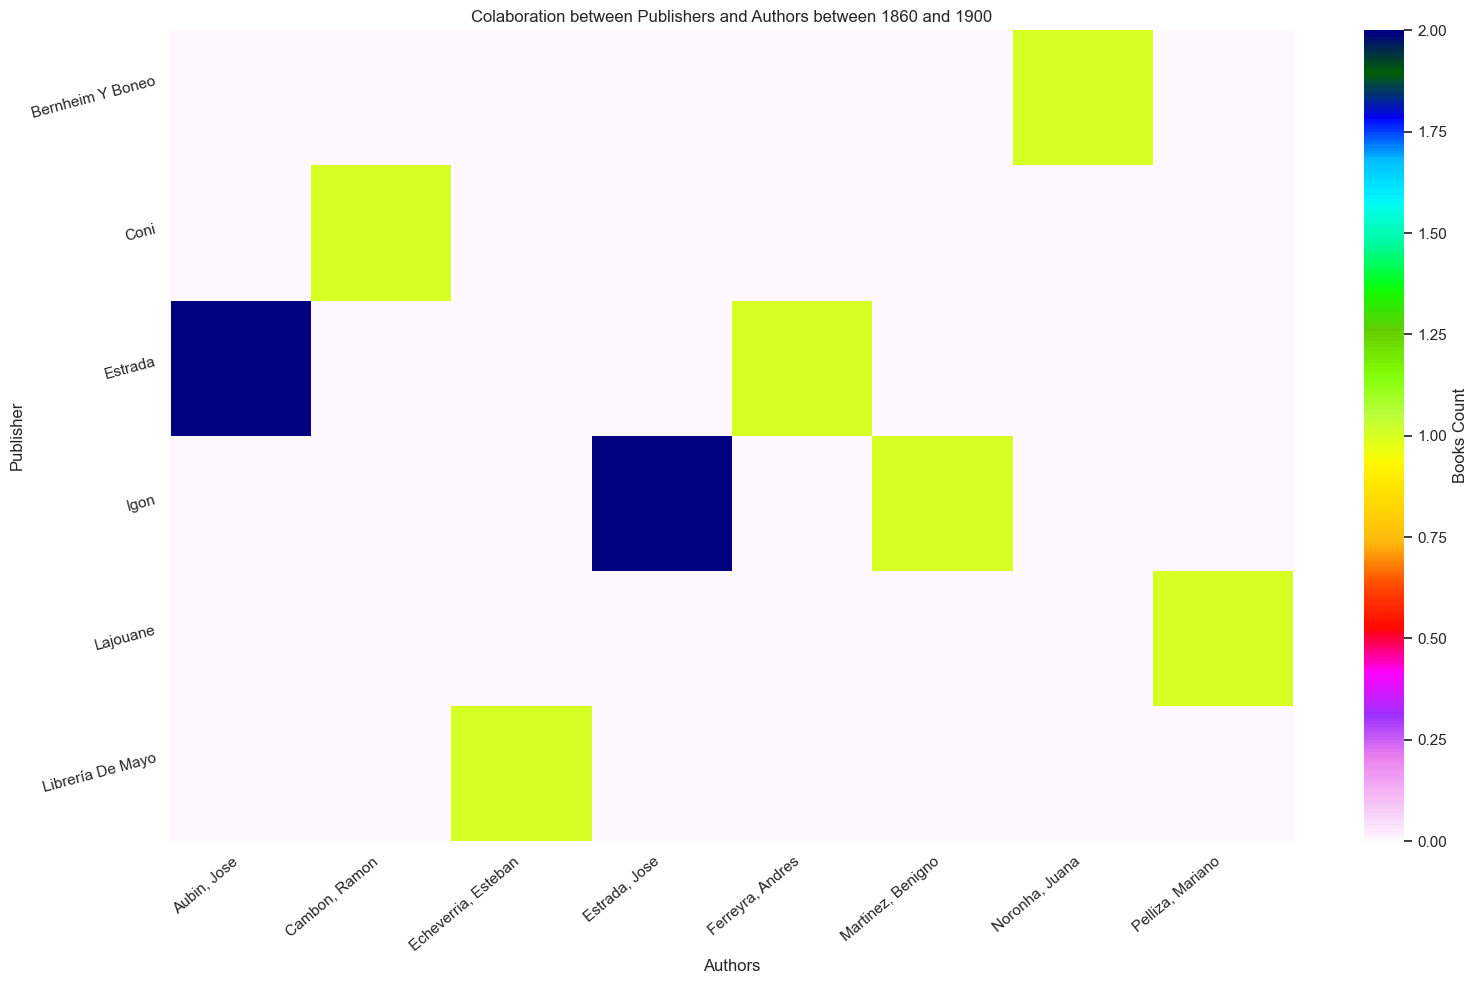

In [105]:

plt.figure(figsize=(16, 10))
""" vmax = 45 """
(df
 .explode('Authors')
 .pipe(lambda d: d[
        #d['Publisher'].isin(d['Publisher'].value_counts().nlargest(25).index) &
        #d['Authors'].isin(d['Authors'].value_counts().nlargest(25).index) &
        (d['Year'] >= 1860) & (d['Year'] < 1900)
    ])
 .pipe(lambda d: sns.heatmap(
     pd.crosstab(d['Publisher'], d['Authors']),
     cmap='gist_ncar_r',
     annot=False,
     fmt='d',
     linecolor='gray',
     cbar_kws={'label': 'Books Count'}
    #vmax=vmax
 ))
)
plt.title('Colaboration between Publishers and Authors between 1860 and 1900')
plt.xlabel('Authors')
plt.ylabel('Publisher')
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

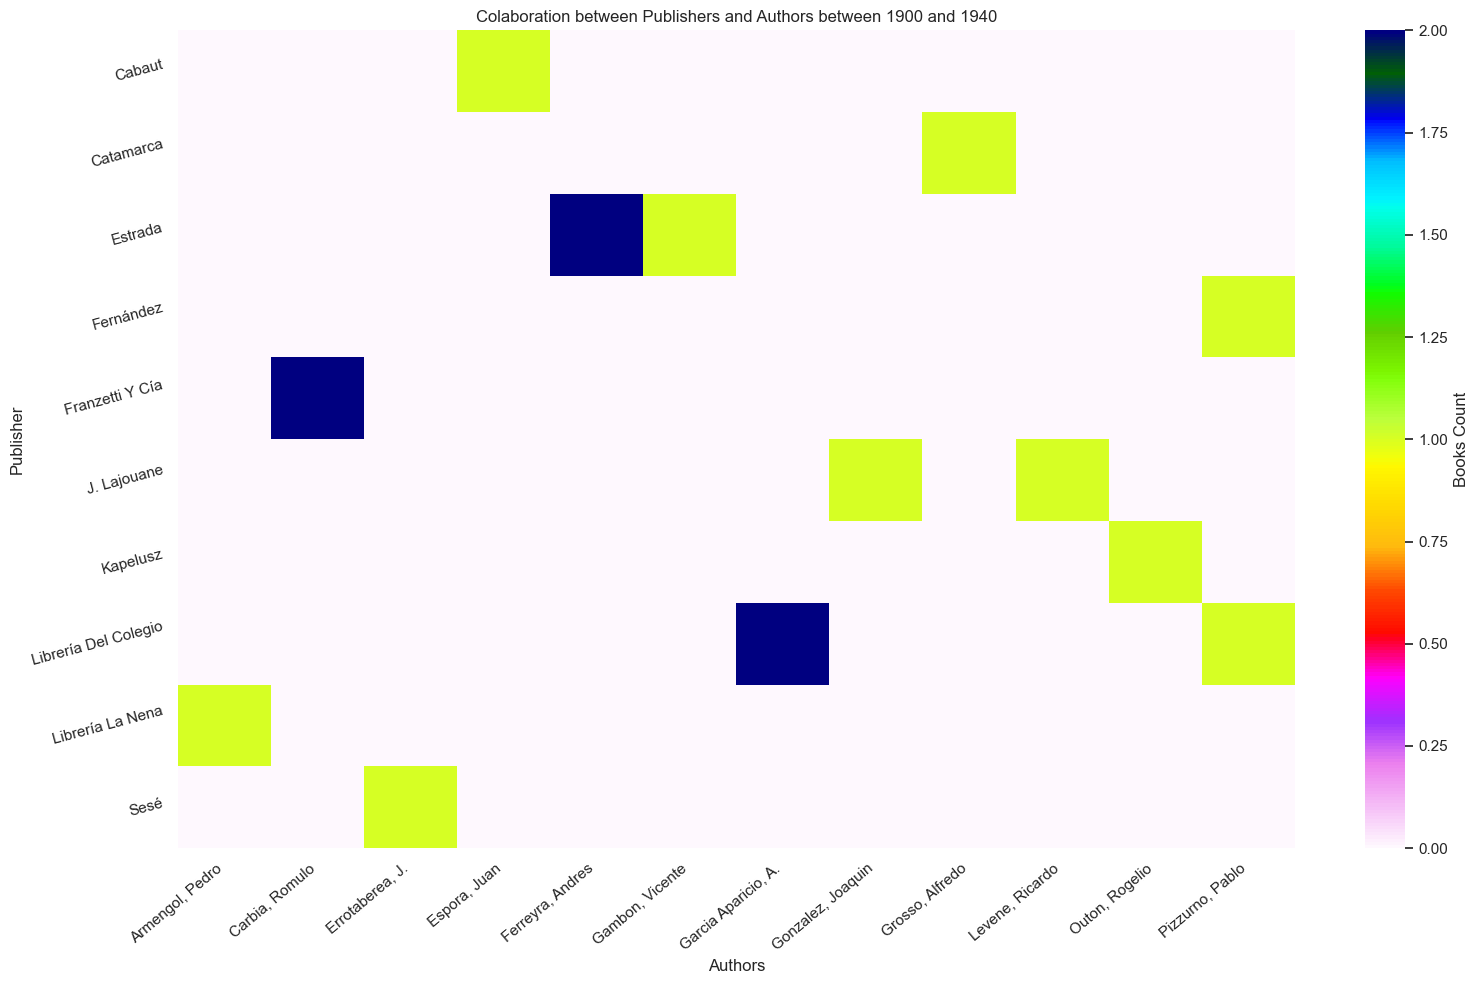

In [68]:
# Heatmap of Publishers vs Authors for decades

plt.figure(figsize=(16, 10))
""" vmax = 45 """
(df
 .explode('Authors')
 .pipe(lambda d: d[
        #d['Publisher'].isin(d['Publisher'].value_counts().nlargest(25).index) &
        #d['Authors'].isin(d['Authors'].value_counts().nlargest(25).index) &
        (d['Year'] >= 1900) & (d['Year'] < 1940)
    ])
 .pipe(lambda d: sns.heatmap(
     pd.crosstab(d['Publisher'], d['Authors']),
     cmap='gist_ncar_r',
     annot=False,
     fmt='d',
     linecolor='gray',
     cbar_kws={'label': 'Books Count'}
    #vmax=vmax
 ))
)
plt.title('Colaboration between Publishers and Authors between 1900 and 1940')
plt.xlabel('Authors')
plt.ylabel('Publisher')
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

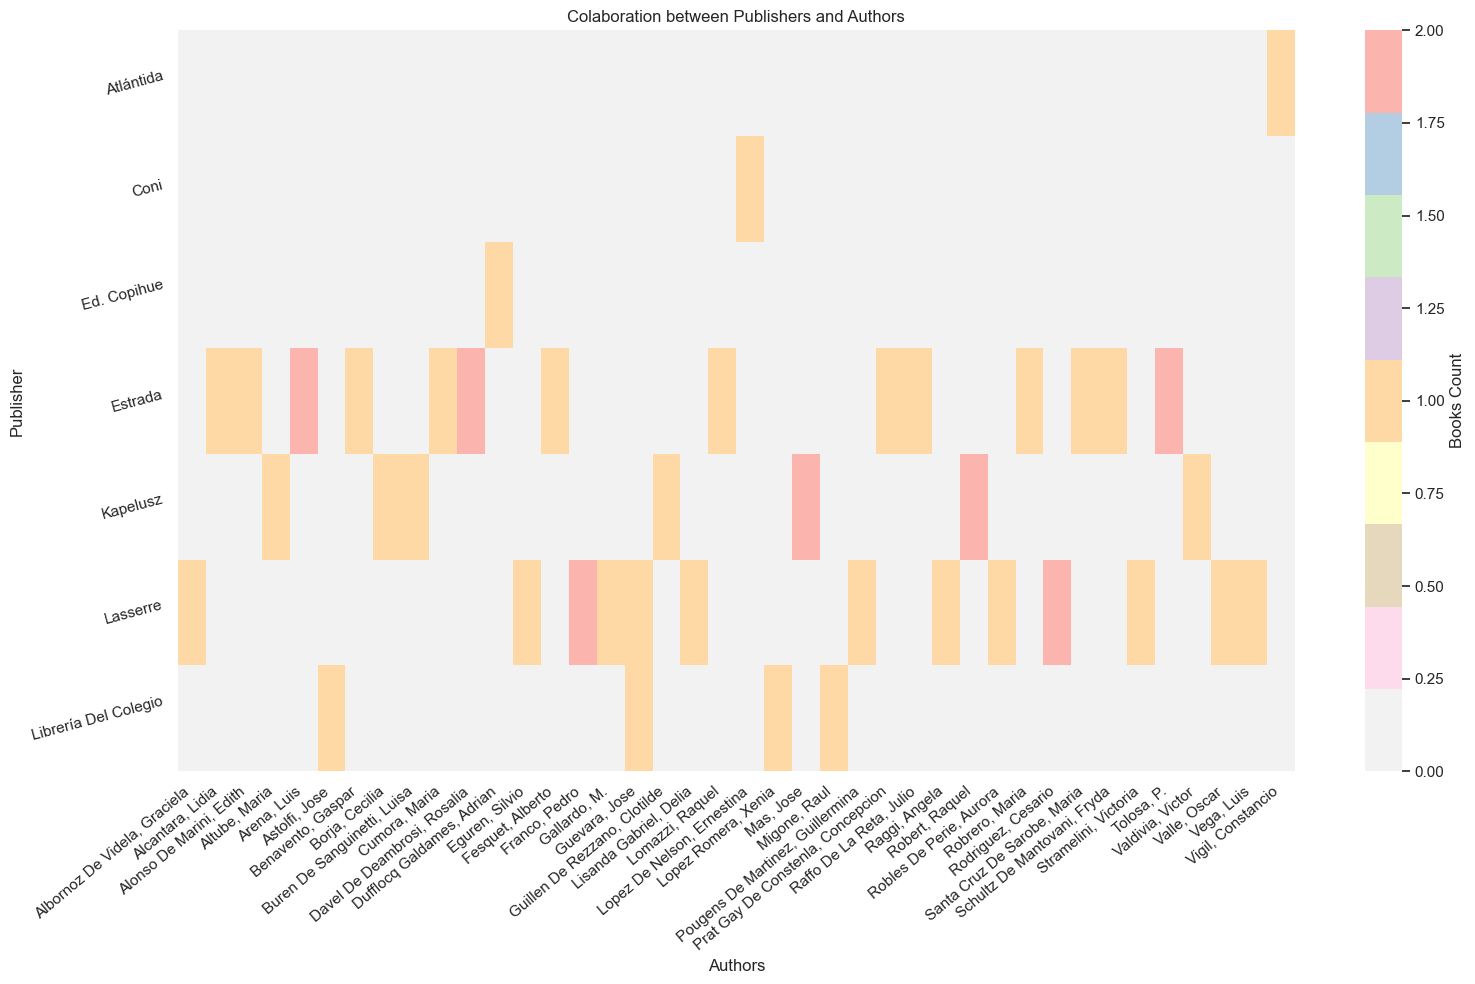

In [103]:
# Heatmap of Publishers vs Authors for decades

plt.figure(figsize=(16, 10))
""" vmax = 45 """
(df
 .explode('Authors')
 .pipe(lambda d: d[
        #d['Publisher'].isin(d['Publisher'].value_counts().nlargest(35).index) &
        #d['Authors'].isin(d['Authors'].value_counts().nlargest(35).index) &
        (d['Year'] >= 1940) & (d['Year'] < 1960)
    ])
 .pipe(lambda d: sns.heatmap(
     pd.crosstab(d['Publisher'], d['Authors']),
     cmap='Pastel1_r',
     annot=False,
     fmt='d',
     linecolor='gray',
     cbar_kws={'label': 'Books Count'}
    #vmax=vmax
 ))
)
plt.title('Colaboration between Publishers and Authors')
plt.xlabel('Authors')
plt.ylabel('Publisher')
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

#### Heatmap of Subjects vs Authors

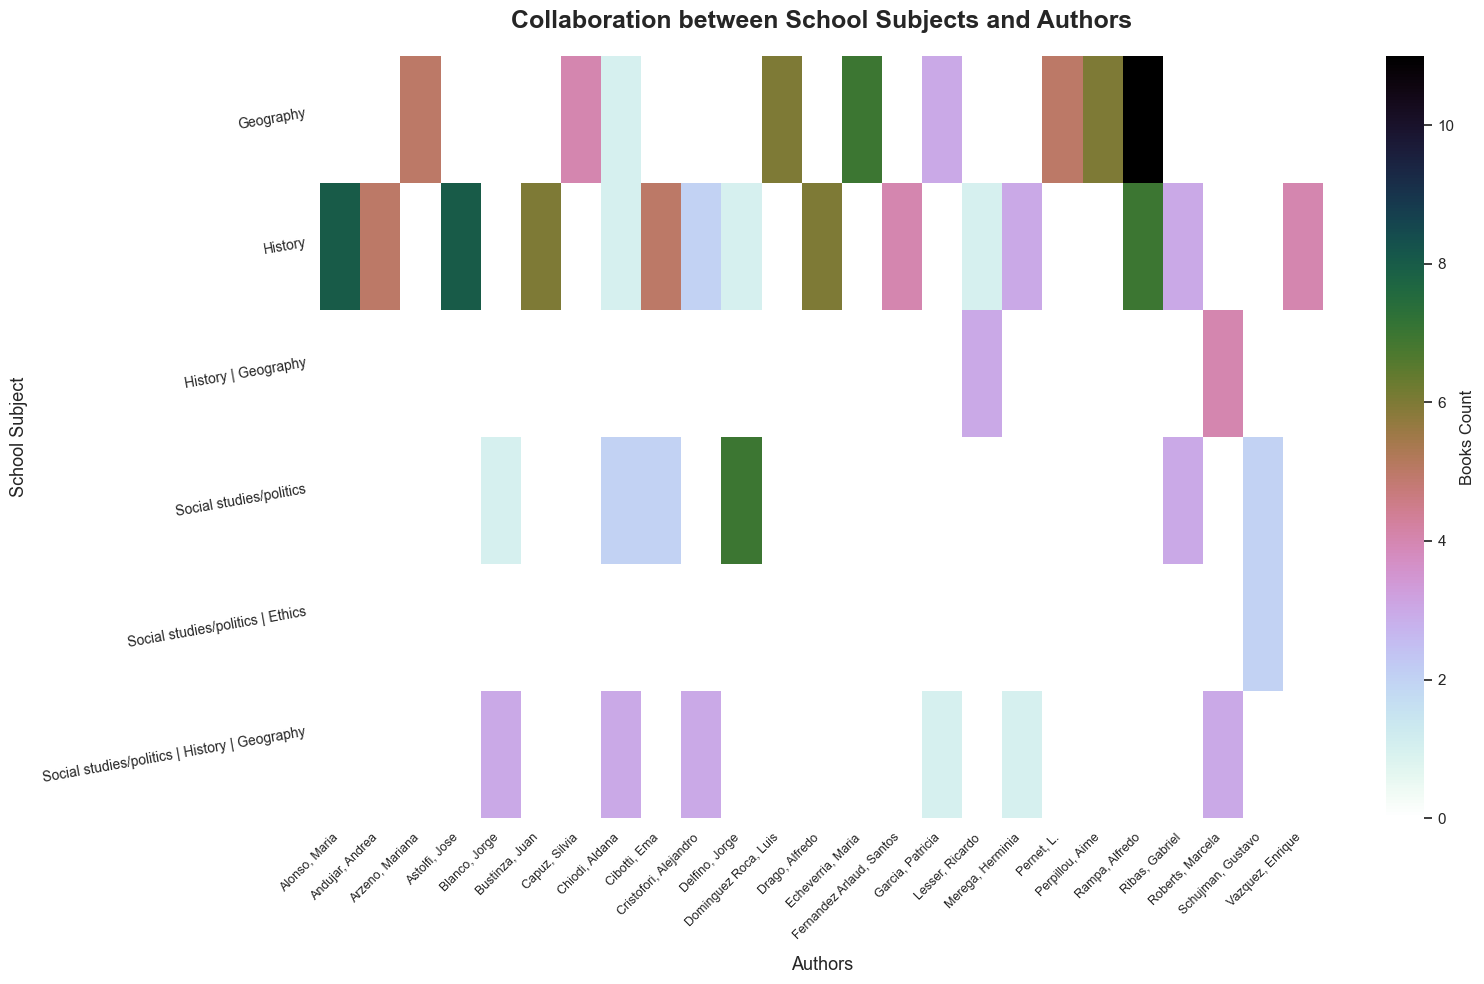

In [ ]:

plt.figure(figsize=(16, 10))
""" vmax = 25 """
(df
 .explode('Authors')
 .query("`School Subject` != 'German taught in non-German-speaking countries'")
 .pipe(lambda d: d[
        d['School Subject'].isin(d['School Subject'].value_counts().nlargest(25).index) &
        d['Authors'].isin(d['Authors'].value_counts().nlargest(25).index) 
    ])
 .pipe(lambda d: sns.heatmap(
     pd.crosstab(d['School Subject'], d['Authors']),
     cmap='cubehelix_r',
     annot=False,
     fmt='d',
     linecolor='gray',
     cbar_kws={'label': 'Books Count'},
     #vmax=vmax
 ))
)
plt.title('Collaboration between School Subjects and Authors', fontsize=18, pad=20, weight='bold')
plt.xlabel('Authors', fontsize=13, labelpad=10)
plt.ylabel('School Subject', fontsize=13, labelpad=10)

# Ejes más legibles
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=10, fontsize=10)

# Quita marcos visuales innecesarios
sns.despine(left=True, bottom=True)

# Mejora el espacio general
plt.tight_layout()
plt.show()

### New column to decades

In [106]:
# column with decades of publication
df['YearInterval'] = pd.cut(df['Year'], bins=list(range(1860, 2021, 10)))
print(df['YearInterval'].value_counts().sort_index())

YearInterval
(1860, 1870]     1
(1870, 1880]     1
(1880, 1890]     1
(1890, 1900]     6
(1900, 1910]     4
(1910, 1920]     6
(1920, 1930]     4
(1930, 1940]     4
(1940, 1950]    10
(1950, 1960]    34
(1960, 1970]    63
(1970, 1980]    23
(1980, 1990]    43
(1990, 2000]    14
(2000, 2010]    49
(2010, 2020]    72
Name: count, dtype: int64


## dejamos como mirada general y luego hacer gráficos separados por intervalo de 40 años 

C:\Users\Adm\AppData\Local\Temp\ipykernel_26784\1838402305.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_exploded.groupby(["YearInterval", "Publisher", "School Subject", "Authors"])


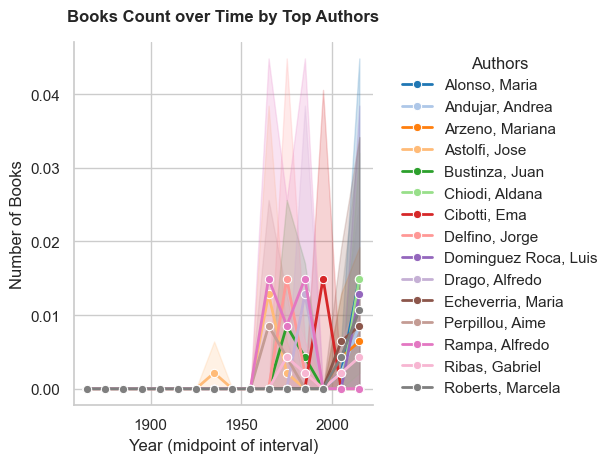

In [109]:
# Time series of book counts by authors
df_exploded = df.explode("Authors")

# Count books by YearInterval, Publisher, School Subject, and Authors
counts = (
    df_exploded.groupby(["YearInterval", "Publisher", "School Subject", "Authors"])
    .size()
    .reset_index(name="Count")
)
# Not sure if needed YearMid 
# transform YearInterval to its midpoint for plotting
counts['YearMid'] = counts['YearInterval'].apply(lambda x: x.mid if pd.notnull(x) else None)

# top authors for plotting
top_authors = (
    counts.groupby("Authors")["Count"].sum().nlargest(15).index
)
counts_top = counts[counts["Authors"].isin(top_authors)]

sns.lineplot(
    data=counts_top,   # filter to top authors
    x="YearMid",
    y="Count",
    hue="Authors",
    marker="o",
     linewidth=2,
    palette="tab20",
)

# Labels and style
plt.title("Books Count over Time by Top Authors", pad=15, weight="bold")
plt.xlabel("Year (midpoint of interval)")
plt.ylabel("Number of Books")
plt.legend(title="Authors", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

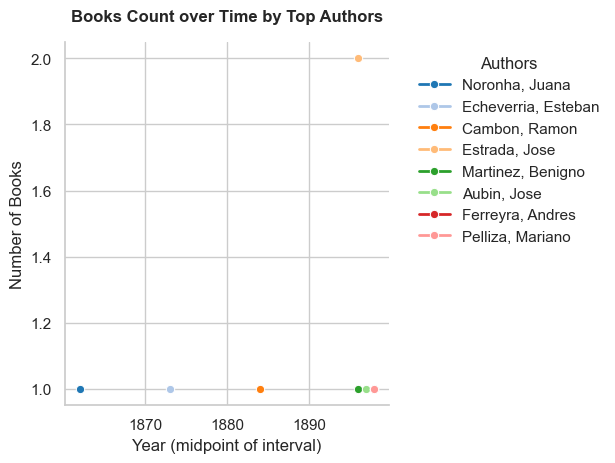

In [115]:
# Time series of book counts by authors
sns.lineplot(
    data=(
        df[df['Year'].between(1860, 1899)]  # filtrar años
          .explode("Authors")              # separar autores en filas individuales
          .groupby(["Year", "Publisher", "School Subject", "Authors"])
          .size()
          .reset_index(name="Count")
    ),
    x="Year",
    y="Count",
    hue="Authors",
    marker="o",
    linewidth=2,
    palette="tab20",
)

# Labels and style
plt.title("Books Count over Time by Top Authors", pad=15, weight="bold")
plt.xlabel("Year (midpoint of interval)")
plt.ylabel("Number of Books")
plt.legend(title="Authors", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

C:\Users\Adm\AppData\Local\Temp\ipykernel_25748\2285567902.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_exploded.groupby(["YearInterval", "Publisher", "School Subject", "Authors"])


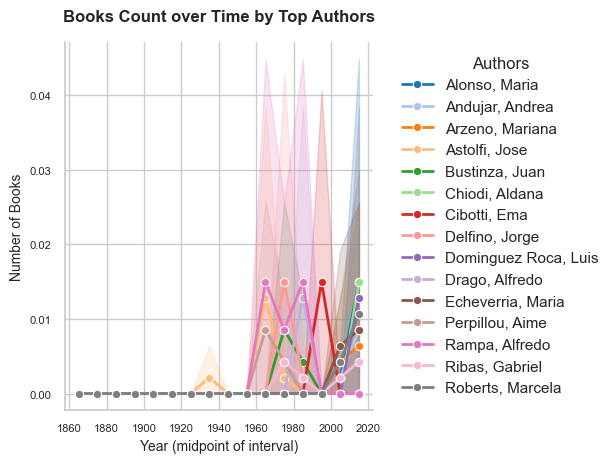

In [ ]:
# Time series of book counts by authors
df.explode("Authors"),
    (df['Year'] >= 1860) & (df['Year'] < 1900),
    .groupby(["Publisher", "School Subject", "Authors"])
    .size()
    .reset_index(name="Count"))

# Count books by Year, Publisher, School Subject, and Authors
sns.lineplot( 
    x="Year",
    y="Count",
    hue="Authors",
    marker="o",
     linewidth=2,
    palette="tab20",
)

# Labels and style
plt.title("Books Count over Time by Top Authors", pad=15, weight="bold")
plt.xlabel("Year (midpoint of interval)")
plt.ylabel("Number of Books")
plt.legend(title="Authors", bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

## ver tema nodos solos

C:\Users\Adm\AppData\Local\Temp\ipykernel_25748\1972448865.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_exploded.groupby(['YearInterval', 'Publisher'])


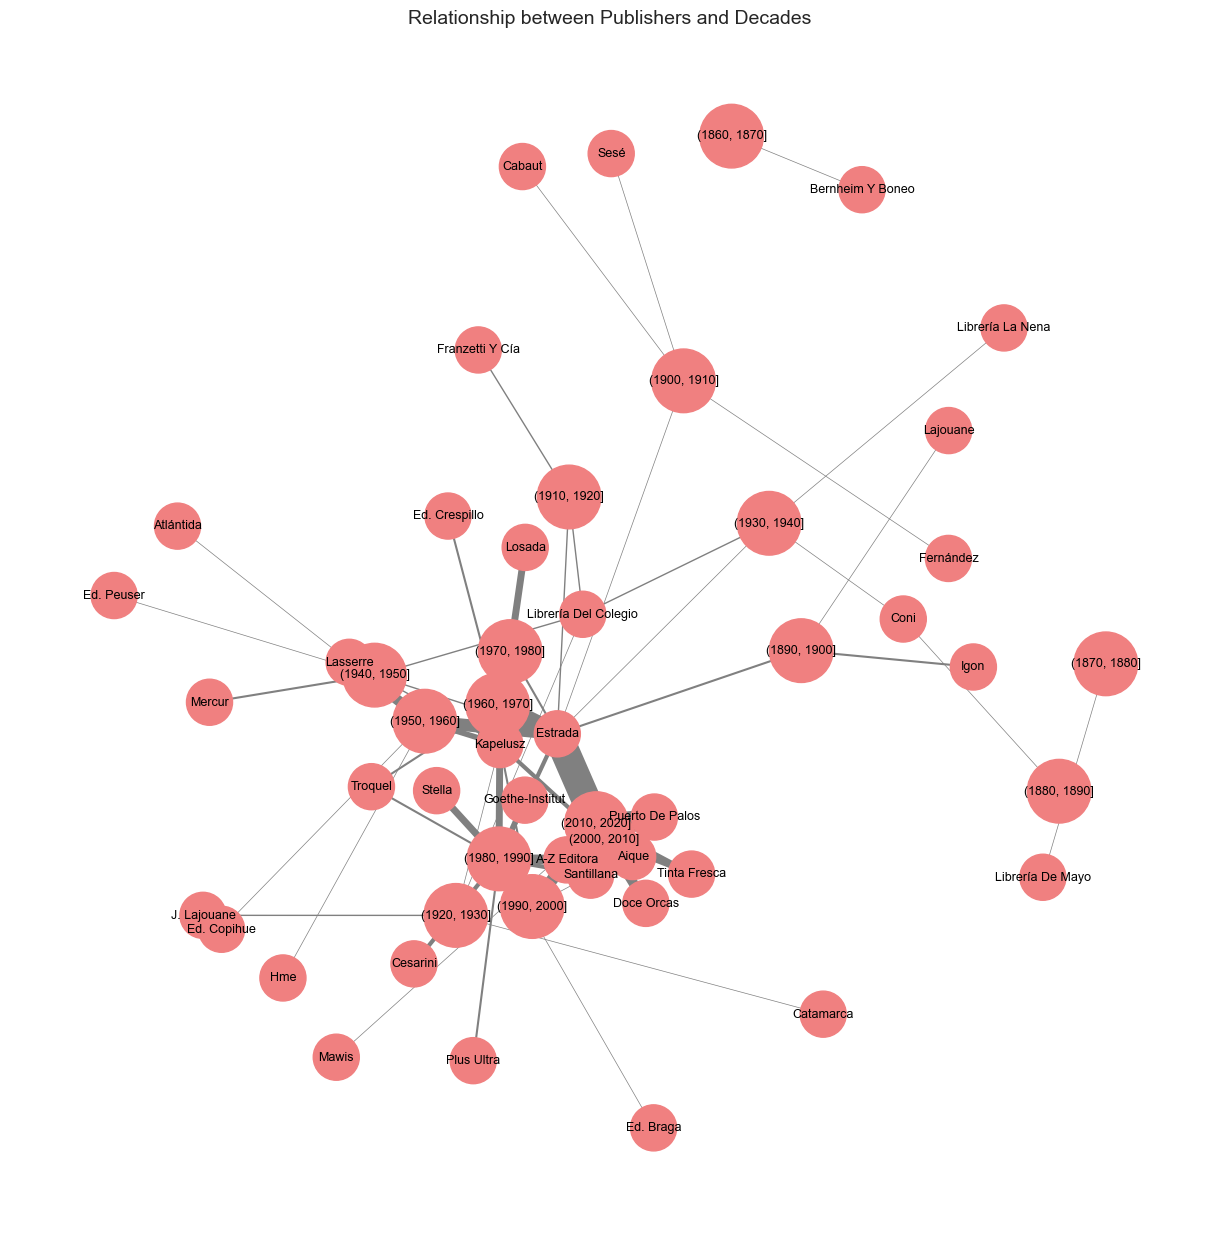

In [22]:
# mejorar esto NO ME GUSTA MUCHO
# Build edgelist for decades and publishers
edgelist = (
    df_exploded.groupby(['YearInterval', 'Publisher'])
    .size()
    .reset_index(name='weight')
)

# build graph
G = nx.from_pandas_edgelist(
    edgelist,
    source="YearInterval",
    target="Publisher",
    edge_attr="weight"
)

# Graph visualization
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k=1.0, iterations=100, seed=42)

# Edge weights
weights = [G[u][v]['weight']*0.5 for u,v in G.edges()]


# colors for decades vs publishers
node_colors = [
    "lightblue" if isinstance(node, float) or isinstance(node,int) else "lightcoral"
    for node in G.nodes()
]

# proportional node sizes
node_sizes = [300 + 50*G.degree(n) for n in G.nodes()]

nx.draw(
    G, pos, with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color='gray',
    width=weights,
    font_size=9
)

plt.title("Relationship between Publishers and Decades", fontsize=14)
plt.show()


## sumar peso por nodo, dejar un general y luego por intervalos de 40 años o por década

C:\Users\Adm\AppData\Local\Temp\ipykernel_25748\3443401510.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_exploded.groupby(['YearInterval', 'Publisher'])


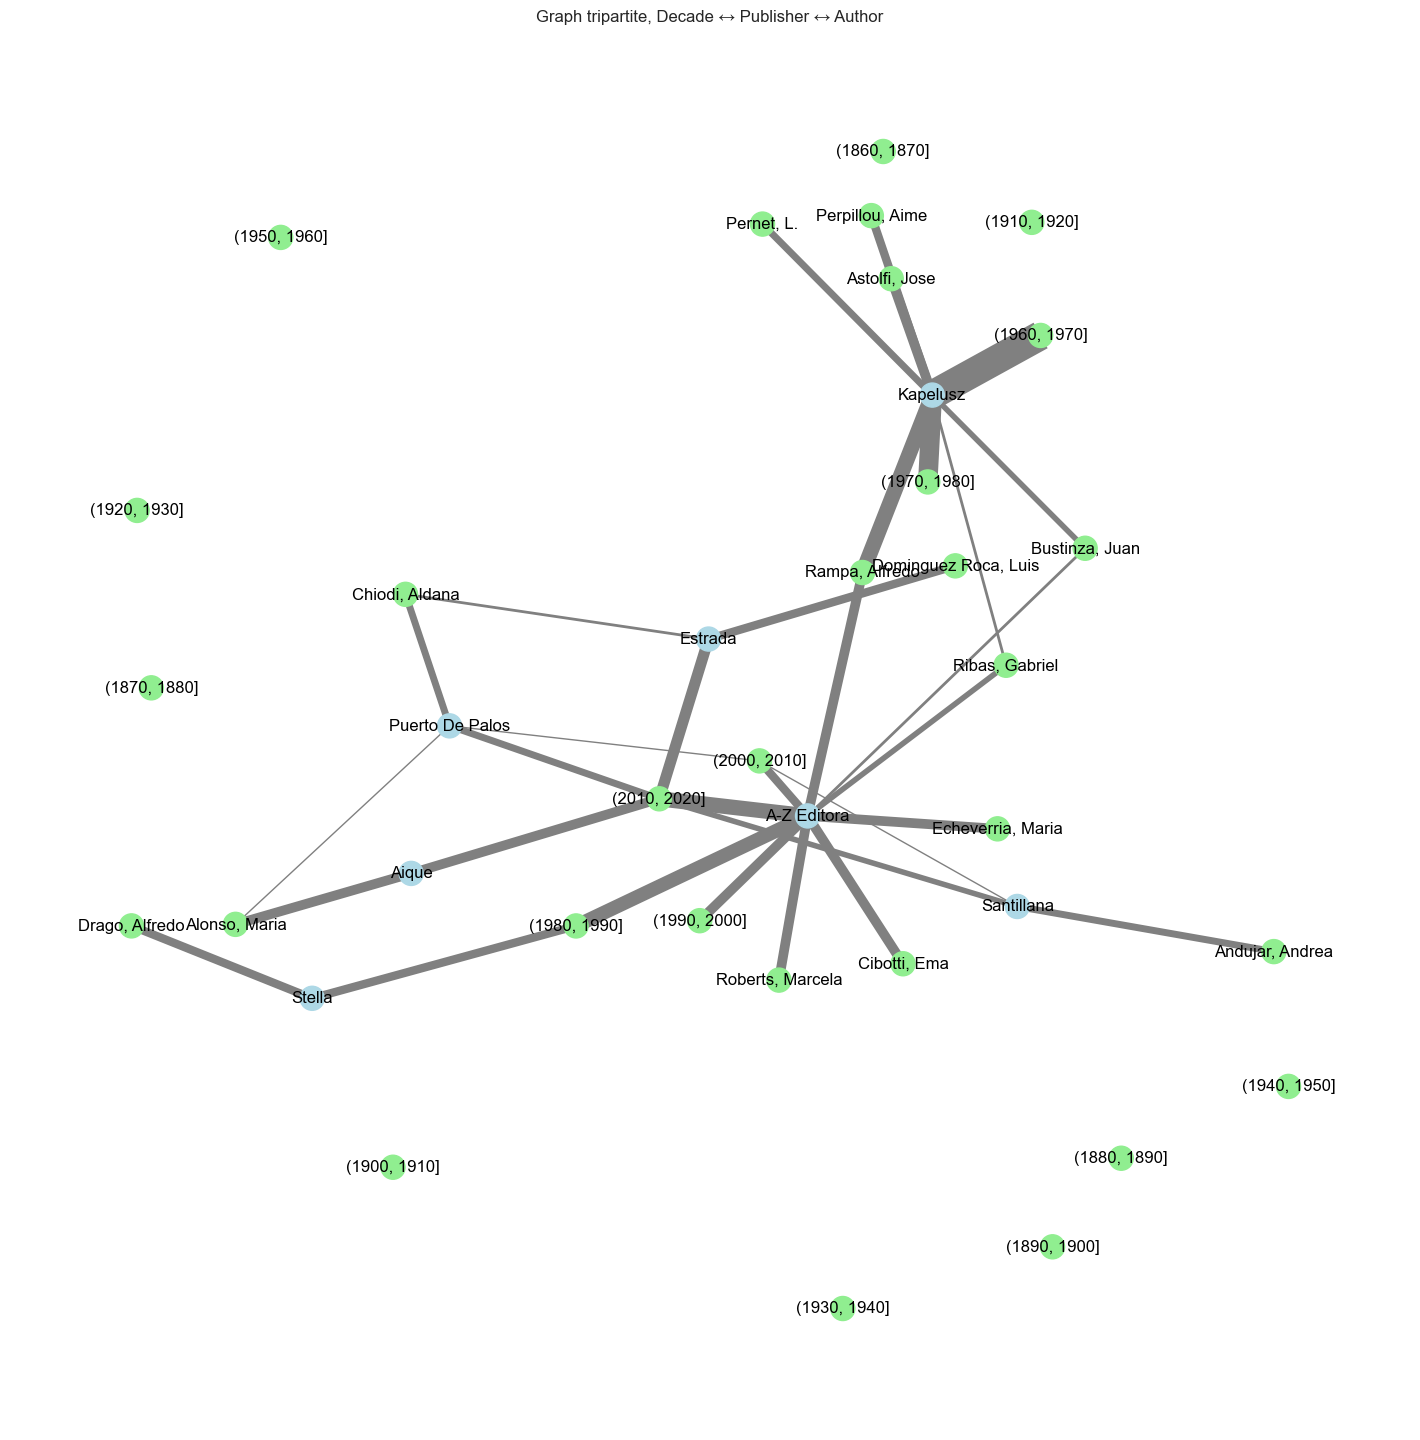

In [23]:
df_exploded = df_exploded[
    df_exploded['Publisher'].isin(df_exploded['Publisher'].value_counts().nlargest(10).index) &
    df_exploded['Authors'].isin(df_exploded['Authors'].value_counts().nlargest(15).index) 
]

# build edgelist for Decade ↔ Publisher
edges_decade_publisher = (
    df_exploded.groupby(['YearInterval', 'Publisher'])
    .size()
    .reset_index(name='weight')
)

# build edgelist for Publisher ↔ Author
edges_publisher_author = (
    df_exploded.groupby(['Publisher', 'Authors'])
    .size()
    .reset_index(name='weight')
)

common_publishers = set(edges_decade_publisher['Publisher']).intersection(edges_publisher_author['Publisher'])

edges_decade_publisher = edges_decade_publisher[
    edges_decade_publisher['Publisher'].isin(common_publishers)
]
edges_publisher_author = edges_publisher_author[
    edges_publisher_author['Publisher'].isin(common_publishers)
]

# graph tripartite
G = nx.Graph()

# new edges decade ↔ Publisher
for _, row in edges_decade_publisher.iterrows():
    G.add_edge(row['YearInterval'], row['Publisher'], weight=row['weight'])

# new edges Publisher ↔ Author
for _, row in edges_publisher_author.iterrows():
    G.add_edge(row['Publisher'], row['Authors'], weight=row['weight'])

# delete isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# graph visualization
plt.figure(figsize=(14,14))
pos = nx.spring_layout(G, k=0.8, seed=42)

# weights for edges
pesos = [G[u][v]['weight'] for u,v in G.edges()]

# colors for node types
node_colors = []
for node in G.nodes():
    if isinstance(node, (int, float)):
        node_colors.append('lightcoral')   # Decade
    elif node in df_exploded['Publisher'].unique():
        node_colors.append('lightblue')    # Publisher
    else:
        node_colors.append('lightgreen')   # Author

nx.draw(
    G, pos, with_labels=True,
    node_color=node_colors,
    edge_color='gray',
    width=pesos
)

plt.title("Graph tripartite, Decade ↔ Publisher ↔ Author")
plt.show()

## no sirve de mucho, ver si puedo mejorar

<Figure size 1400x800 with 0 Axes>

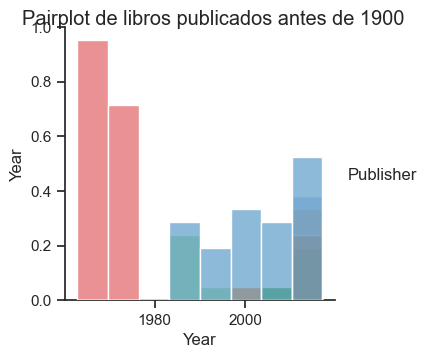

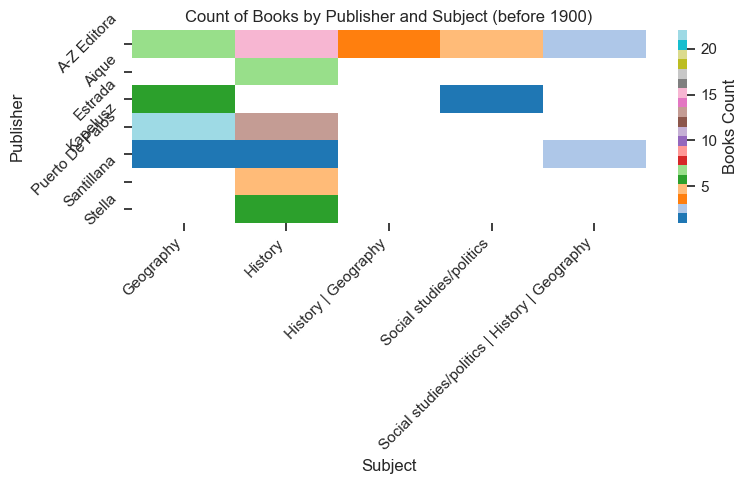

In [24]:

# Pairplot of Year vs Publisher for books before 1900
plt.figure(figsize=(14, 8))
sns.set(style="ticks", palette="tab20")

sns.pairplot(df_exploded, vars=['Year'], hue='Publisher', diag_kind='hist', palette='tab20', height=3.5)
plt.suptitle('Pairplot de libros publicados antes de 1900', y=1.0)

# Heatmap of Publishers vs School Subjects for books before 1900
plt.figure(figsize=(8, 5))
ax2 = sns.heatmap(
    pd.crosstab(df_exploded['Publisher'], df_exploded['School Subject']),
    cmap='tab20',
    annot=False,
    fmt='d',
    linecolor='gray',
    cbar_kws={'label': 'Books Count'},
    mask=(pd.crosstab(df_exploded['Publisher'], df_exploded['School Subject']) <= 0)
)
plt.title('Count of Books by Publisher and Subject (before 1900)')
plt.xlabel('Subject')
plt.ylabel('Publisher')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## ver peso de autores en nodo de editoriales lejanas, dejar este como general y periodizarlo, en intervalos de 40 años o menos

In [25]:
# prepare data for network graph
df_exploded = df.explode('Authors')
df_network = df_exploded[['Publisher', 'Authors']].dropna().copy()

# build graph bipartite Publisher ↔ Author
G = nx.from_pandas_edgelist(
    df_network, 
    source='Publisher', 
    target='Authors', 
    create_using=nx.Graph()
)

# graph visualization focusing on top nodes
node_degrees = dict(G.degree())
threshold = sorted(node_degrees.values(), reverse=True)[25] # nodes with degree >= threshold

nodes_to_draw = [node for node, degree in node_degrees.items() if degree >= threshold or node in top_publishers]
subgraph = G.subgraph(nodes_to_draw)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph, k=0.15, iterations=20) # layout algorithm

# split nodes by type for coloring
publishers_nodes = [n for n in subgraph.nodes() if n in df_network['Publisher'].unique()]
authors_nodes = [n for n in subgraph.nodes() if n in df_network['Authors'].explode().unique()]

# draw nodes
nx.draw_networkx_nodes(
    subgraph, pos, 
    nodelist=publishers_nodes, 
    node_color='skyblue', 
    node_size=800, 
    label='Publishers'
)
nx.draw_networkx_nodes(
    subgraph, pos, 
    nodelist=authors_nodes, 
    node_color='lightcoral', 
    node_size=200, 
    label='Authors'
)

# drwar edges y labels
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.title('Network of Authors and Publishers (Top 25 nodes)', fontsize=16, weight='bold')
plt.legend()
plt.tight_layout()
plt.axis('off')
plt.show()

NameError: name 'top_publishers' is not defined

In [ ]:

# Graph with Plotly Express: Animated Bar Chart of Subject Distribution by Publisher over Decades

fig = px.bar(
        df.groupby([
                'YearInterval', 
                df['School Subject'].str.split().str.slice(0, 3).str.join(' '),  # cut subject to first 3 words
                'Publisher'
            ]).size().reset_index(name='Books Count'),
    x="School Subject",
    y="Books Count",
    color="Publisher",
    animation_frame="YearInterval", # decade animation
    title="Subject Distribution by Publisher over Decades",
    category_orders={"YearInterval": sorted(df['YearInterval'].unique())}
)
# rotate x-axis labels to avoid overlap
fig.update_xaxes(
    tickangle=45,
    automargin=True
)

# move menu and slider down to avoid overlap with x-axis labels
fig.update_layout(
    margin=dict(b=100),  # move bottom margin
    updatemenus=[{
        "type": "buttons",
        "showactive": False,
        "x": -0.05,       # move buttons to the left
        "y": -0.35,      # move buttons 
        "xanchor": "left",
        "yanchor": "top"
    }],
    sliders=[{
        "x": 0.1,        # move slider 
        "y": -0.55,      # move slider down
        "xanchor": "left",
        "yanchor": "top"
    }]
)

fig.show()

C:\Users\Adm\AppData\Local\Temp\ipykernel_27788\3696282210.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

